## 概要

- efficientnet(gloval_average_pooling => gemに変更) + arcface を用いて meigara の予測 タスクを実行
- **arcface lossのパラメータが更新されないようになっていたので更新するように修正**
- 学習済みモデルを用いて test, cite の画像の embedding を取得し、それらの距離から類似画像を選択

## Library

In [1]:
import datetime
import gc
import itertools
import json
import logging
import os
import shutil
import math
from pathlib import Path

import albumentations as A
import cv2
import japanize_matplotlib
import joblib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import requests
import timm
import torch
import torch.nn as nn
import torch.nn.functional as F

from albumentations import ImageOnlyTransform
from albumentations.pytorch import ToTensorV2
from cosine_annealing_warmup import CosineAnnealingWarmupRestarts
from PIL import Image
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import LabelEncoder
from torch.cuda.amp import GradScaler, autocast
from torch.optim import Adam, AdamW
from torch.optim.lr_scheduler import (
    CosineAnnealingLR,
    CosineAnnealingWarmRestarts,
    MultiStepLR,
    ReduceLROnPlateau,
)
from torch.utils.data import DataLoader, Dataset
from tqdm import tqdm
from transformers import get_cosine_schedule_with_warmup, get_linear_schedule_with_warmup
from torch.utils.tensorboard import SummaryWriter
import faiss
from pytorch_metric_learning import losses

from src.const import OUTPUT_ROOT, DATA_ROOT, QUERY_IMAGES_PATH, CITE_IMAGES_PATH
from src.layer import GeM
from src.utils import seed_torch

## Config

In [2]:
class Config:
    competition = "sake"
    name = "arcface_with_tf_efficientnet_b0_ns_apply_gem_metrics_params_optim"

    debug = False

    training = True
    evaluation = True
    embedding = True

    seed = 8823
    n_fold = 5
    trn_fold = [0,1,2,3,4]
    scale = 30

    target_columns = ["meigara_label"]
    size = 512

    model_name = "tf_efficientnet_b0.ns_jft_in1k"
    max_epochs = 5
    train_batch_size = 16
    valid_batch_size = 64
    num_workers = 4
    gradient_accumulation_steps = 1
    clip_grad_norm = 1000

    optimizer = dict(
        optimizer_name="AdamW",
        lr=1e-4,
        weight_decay=1e-2,
        eps=1e-6,
        beta=(0.9, 0.999),
        encoder_lr=1e-4,
        decoder_lr=1e-4,
    )

    scheduler = dict(
        scheduler_name="cosine",
        num_warmup_steps_rate=0,
        num_cycles=0.5,
    )
    batch_scheduler = True


if Config.debug:
    Config.max_epochs = 2
    Config.n_fold = 2
    Config.trn_fold = [0, 1]
    Config.name = Config.name + "_debug"
    Config.size = 128
    Config.train_batch_size = 8

## Const

In [3]:
# constants
HOME = OUTPUT_ROOT / 'train_arcface'
EXP_NAME = Config.name
INPUTS = DATA_ROOT  # input data
OUTPUTS = HOME / "outputs"
INTERMIDIATES = HOME / "intermidiates"  # intermidiate outputs
SUBMISSIONS = HOME / "submissions"
OUTPUTS_EXP = OUTPUTS / EXP_NAME
EXP_MODELS = OUTPUTS_EXP / "models"
EXP_REPORTS = OUTPUTS_EXP / "reports"
EXP_PREDS = OUTPUTS_EXP / "predictions"

CITE_IMAGES = CITE_IMAGES_PATH
QUERY_IMAGES = QUERY_IMAGES_PATH

## Setup

In [4]:
def setup(Config):

    for d in [
        HOME,
        INPUTS,
        SUBMISSIONS,
        EXP_MODELS,
        EXP_REPORTS,
        EXP_PREDS,
        INTERMIDIATES,
    ]:
        d.mkdir(parents=True, exist_ok=True)

def check_file_exists(folder_path, file_name):
    folder = Path(folder_path)
    for file_path in folder.glob("**/*"):
        if file_path.is_file() and file_path.stem == file_name:
            return True
    return False


def create_new_datasets_in_kaggle(dataset_name, upload_dir):
    from kaggle.api.kaggle_api_extended import KaggleApi

    dataset_metadata = {}
    dataset_metadata["id"] = f'{os.environ["KAGGLE_USERNAME"]}/{dataset_name}'
    dataset_metadata["licenses"] = [{"name": "CC0-1.0"}]
    dataset_metadata["title"] = dataset_name
    with open(os.path.join(upload_dir, "dataset-metadata.json"), "w") as f:
        json.dump(dataset_metadata, f, indent=4)
    api = KaggleApi()
    api.authenticate()
    api.dataset_create_new(folder=upload_dir, convert_to_csv=False, dir_mode="tar")


class Logger:
    def __init__(self, path):
        self.general_logger = logging.getLogger(path)
        stream_handler = logging.StreamHandler()
        file_general_handler = logging.FileHandler(os.path.join(path, "Experiment.log"))
        if len(self.general_logger.handlers) == 0:
            self.general_logger.addHandler(stream_handler)
            self.general_logger.addHandler(file_general_handler)
            self.general_logger.setLevel(logging.INFO)

    def info(self, message):
        # display time
        self.general_logger.info("[{}] - {}".format(self.now_string(), message))

    @staticmethod
    def now_string():
        return str(datetime.datetime.now().strftime("%Y-%m-%d %H:%M:%S"))


def copy_file(source_file, destination_file):
    try:
        shutil.copy(source_file, destination_file)
        print("copy complete")
    except IOError as e:
        print(f"copy error: {e}")

In [5]:
setup(Config)
LOGGER = Logger(OUTPUTS_EXP.as_posix())
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

## Load data

In [6]:
def make_train_label(train_df) -> pd.DataFrame:
    le = LabelEncoder()
    train_df["brand_id_label"] = le.fit_transform(train_df["brand_id"])
    train_df["meigara_label"] = le.fit_transform(train_df["meigara"])

    return train_df


def make_filepath(input_df):
    def join_path(dirpath, filename):
        return (dirpath / filename).as_posix()

    output_df = input_df.assign(
        filepath=input_df["filename"].apply(
            lambda x: join_path(QUERY_IMAGES, x) if str(x)[0] == "2" else join_path(CITE_IMAGES, x)
        )
    )
    return output_df

def make_label_dict(train_df):
    MLABEL2MEIGARA = train_df[["meigara", "meigara_label"]].set_index("meigara_label").to_dict()["meigara"]
    BLABEL2BLAND = train_df[["brand_id", "brand_id_label"]].set_index("brand_id_label").to_dict()["brand_id"]
    return MLABEL2MEIGARA, BLABEL2BLAND

In [7]:
# load raw data
train_df = pd.read_csv(INPUTS / "train.csv")
test_df = pd.read_csv(INPUTS / "test.csv")
cite_df = pd.read_csv(INPUTS / "cite.csv").rename(columns={"cite_gid":"gid", "cite_filename":"filename"})
sample_submission_df = pd.read_csv(INPUTS / "sample_submission.csv")

if Config.debug:
    train_df = train_df.sample(1000, random_state=Config.seed).reset_index(drop=True)
    cite_df = cite_df.sample(100, random_state=Config.seed).reset_index(drop=True)

# make label
train_df = make_train_label(train_df)
MLABEL2MEIGARA, BLABEL2BLAND = make_label_dict(train_df)
TARGET_DIM = 512  # arcfaceの埋め込み次元

# make filepath
train_df = make_filepath(train_df)
test_df = make_filepath(test_df)
cite_df = make_filepath(cite_df)

# for submission
IDX2CITE_GID = cite_df.to_dict()["gid"]

print(train_df.shape)

(108160, 7)


## CV Split

In [8]:
def add_fold_idx(config, train_df):
    fold = StratifiedKFold(n_splits=config.n_fold, shuffle=True, random_state=config.seed)
    train_df["fold"] = -1
    for i_fold, (train_index, val_index) in enumerate(
        fold.split(train_df, train_df[config.target_columns])
    ):
        train_df.iloc[val_index, train_df.columns.get_loc("fold")] = int(i_fold)
    train_df["fold"] = train_df["fold"].astype(int)
    return train_df

In [9]:
train_df = add_fold_idx(config=Config, train_df=train_df)
train_df.head()

/opt/conda/lib/python3.10/site-packages/sklearn/model_selection/_split.py:725: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(


,gid,filename,brand_id,meigara,brand_id_label,meigara_label,filepath,fold
0,200000001,200000001.jpg,3372,五橋,2211,445,/work/data/query_images/200000001.jpg,3
1,200000002,200000002.jpg,3751,庭のうぐいす,2454,1122,/work/data/query_images/200000002.jpg,4
2,200000003,200000003.jpg,2856,笑四季,1864,1819,/work/data/query_images/200000003.jpg,3
3,200000004,200000004.jpg,1527,鍋島,1005,2263,/work/data/query_images/200000004.jpg,1
4,200000005,200000005.jpg,2676,仙禽,1739,478,/work/data/query_images/200000005.jpg,2


## Dataset

In [10]:
class TrainDataset(Dataset):
    def __init__(self,df, target_columns=Config.target_columns, transform_fn=None):
        self.df = df
        self.file_names = df["filepath"].to_numpy()
        self.targets = df[target_columns].to_numpy()
        if len(target_columns) == 1:
            self.targets = np.ravel(self.targets)

        self.transform_fn = transform_fn

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        filepath = self.file_names[idx]
        image = cv2.imread(filepath)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        if self.transform_fn:
            image = self.transform_fn(image=image)["image"]
        target = torch.tensor(self.targets[idx])
        return {"images":image, "targets":target}


class TestDataset(Dataset):
    def __init__(self, df, transform_fn=None):
        self.df = df
        self.file_names = df["filepath"].to_numpy()
        self.transform_fn = transform_fn

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        filepath = self.file_names[idx]
        image = cv2.imread(filepath)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        if self.transform_fn:
            image = self.transform_fn(image=image)["image"]
        return {"images":image}

## Transforms

In [11]:
def get_transforms(*, size, data="train"):

    if data == 'train':
        return A.Compose([
            # 正方形切り出し
            A.RandomResizedCrop(size, size, scale=(0.85, 1.0)),
            A.Normalize(
                mean=[0.485, 0.456, 0.406],
                std=[0.229, 0.224, 0.225],
            ),
            ToTensorV2(),
        ])

    elif data == 'valid':
        return A.Compose([
            A.Resize(size, size),
            A.Normalize(
                mean=[0.485, 0.456, 0.406],
                std=[0.229, 0.224, 0.225],
            ),
            ToTensorV2(),
        ])

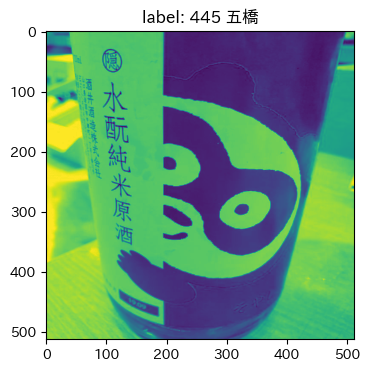

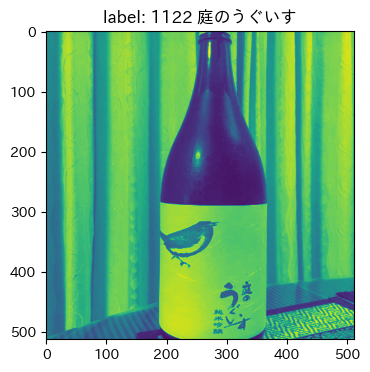

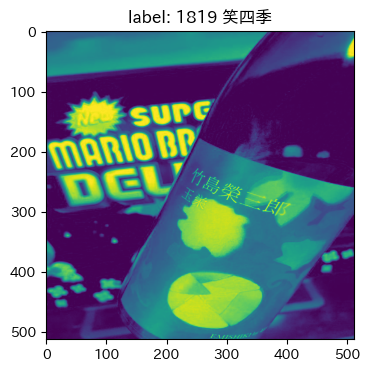

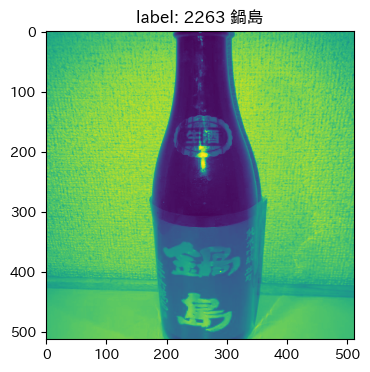

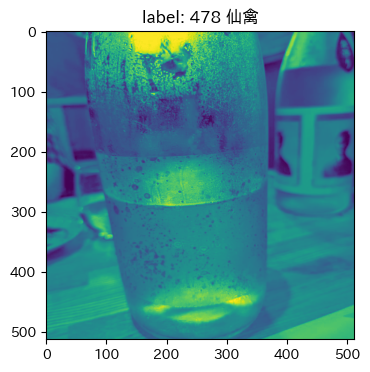

In [12]:
train_dataset = TrainDataset(df=train_df, transform_fn=get_transforms(data="train", size=Config.size))
japanize_matplotlib.japanize()
for i in range(5):
    plt.figure(figsize=(4, 4))
    batch = train_dataset[i]
    image, label = batch["images"],  batch["targets"]
    plt.imshow(image[0])
    plt.title(f"label: {int(label)} {MLABEL2MEIGARA[int(label)]}")
    plt.show()

## Model

In [13]:
class CustomModel(nn.Module):
    def __init__(self, config, out_dim, pretrained=False):
        super().__init__()
        self.config = config
        self.model = timm.create_model(self.config.model_name, pretrained=pretrained)
        self.n_features = self.model.classifier.in_features
        self.model.global_pool = GeM()
        self.model.classifier = nn.Identity()  # custom head にするため
        self.fc = nn.Linear(self.n_features, out_dim)

    def forward(self, images, labels=None):
        bs = images.size(0)
        x = self.model(images).view(bs, -1)
        x = self.fc(x)
        return x

## Funcs

In [14]:
def train_fn(
    config,
    model,
    dataloader,
    criterion,
    optimizer,
    scheduler,
    device,
    _custom_step,
):
    model.train()
    scaler = torch.cuda.amp.GradScaler()
    losses = []

    tbar = tqdm(enumerate(dataloader), total=len(dataloader))
    for step, batch in tbar:
        for k, v in batch.items():
            batch[k] = v.to(device)
        targets = batch["targets"]
        batch_size = targets.size(0)

        with torch.cuda.amp.autocast():
            batch_outputs = model(batch["images"], labels=batch["targets"])
            loss = criterion(batch_outputs, targets)

        if config.gradient_accumulation_steps > 1:
            loss = loss / config.gradient_accumulation_steps

        scaler.scale(loss).backward()
        if config.clip_grad_norm is not None:
            torch.nn.utils.clip_grad_norm_(model.parameters(), config.clip_grad_norm)
            torch.nn.utils.clip_grad_norm_(criterion.parameters(), config.clip_grad_norm)

        if (step + 1) % config.gradient_accumulation_steps == 0:
            scaler.step(optimizer)
            scaler.update()
            optimizer.zero_grad()
            _custom_step += 1
            if config.batch_scheduler:
                scheduler.step()

        losses.append(float(loss))
        tbar.set_description(f"loss: {np.mean(losses):.4f} lr: {scheduler.get_lr()[0]:.6f}")

    loss = np.mean(losses)
    return loss, _custom_step


def valid_fn(
    config,
    model,
    dataloader,
    criterion,
    device,
    _custom_step,
):
    model.eval()
    outputs, targets = [], []
    losses = []

    tbar = tqdm(enumerate(dataloader), total=len(dataloader))
    for step, batch in tbar:
        targets.append(batch["targets"])

        for k, v in batch.items():
            batch[k] = v.to(device)

        batch_size = batch["targets"].size(0)
        with torch.no_grad():
            batch_outputs = model(batch["images"], labels=batch["targets"])
            loss = criterion(batch_outputs, batch["targets"])

        if config.gradient_accumulation_steps > 1:
            loss = loss / config.gradient_accumulation_steps

        batch_outputs = batch_outputs.to("cpu").numpy()
        outputs.append(batch_outputs)

        _custom_step += 1
        losses.append(float(loss))

        tbar.set_description(f"loss: {np.mean(losses):.4f}")

    outputs = np.concatenate(outputs)
    targets = np.concatenate(targets)

    loss = np.mean(losses)
    return (loss, outputs, targets, _custom_step)

In [15]:
def get_optimizer(optimizer_config, params):
    if optimizer_config["optimizer_name"] == "AdamW":
        optimizer = AdamW(
            params,
            lr=optimizer_config["lr"],
            betas=optimizer_config["beta"],
            eps=optimizer_config["eps"],
        )
        return optimizer
    else:
        raise NotImplementedError


def get_scheduler(scheduler_config, optimizer, num_train_steps):
    if scheduler_config["scheduler_name"] == "linear":
        scheduler = get_linear_schedule_with_warmup(
            optimizer,
            num_warmup_steps=int(scheduler_config["num_warmup_steps_rate"] * num_train_steps),
            num_training_steps=num_train_steps,
        )
        return scheduler

    elif scheduler_config["scheduler_name"] == "cosine":
        scheduler = get_cosine_schedule_with_warmup(
            optimizer,
            num_warmup_steps=int(scheduler_config["num_warmup_steps_rate"] * num_train_steps),
            num_training_steps=num_train_steps,
            num_cycles=scheduler_config["num_cycles"],
        )
        return scheduler

    elif scheduler_config["scheduler_name"] == "cosine_restarts":
        """
        example:
            first_cycle_steps_ratio = 0.25,
            cycle_mult = 1.0,
            max_lr = 2e-5,
            min_lr = 1e-7,
            warmup_steps=100,
            gamma=0.8)
        """
        scheduler = CosineAnnealingWarmupRestarts(
            optimizer,
            first_cycle_steps=int(num_train_steps * scheduler_config["first_cycle_steps_ratio"]),
            cycle_mult=scheduler_config["cycle_mult"],
            max_lr=scheduler_config["max_lr"],
            min_lr=scheduler_config["min_lr"],
            warmup_steps=scheduler_config["warmup_steps"],
            gamma=scheduler_config["gamma"],
        )
        return scheduler

    else:
        raise NotImplementedError

In [16]:
def train_loop(config, name, train_df, valid_df, out_dim, device, summary_writer, criterion):
    LOGGER.info(f"========== {name} training ==========")

    # dataset, dataloader
    train_dataset = TrainDataset(
        df=train_df,
        target_columns=config.target_columns,
        transform_fn=get_transforms(data="train", size=config.size)
    )
    valid_dataset = TrainDataset(
        df=valid_df,
        target_columns=config.target_columns,
        transform_fn=get_transforms(data="valid", size=config.size)
    )
    train_dataloader = DataLoader(
        train_dataset,
        batch_size=config.train_batch_size,
        shuffle=True,
        num_workers=config.num_workers,
        pin_memory=True,
        drop_last=True,
    )
    valid_dataloader = DataLoader(
        valid_dataset,
        batch_size=config.valid_batch_size,
        shuffle=False,
        num_workers=config.num_workers,
        pin_memory=True,
        drop_last=False,
    )

    # set model & optimizer
    model = CustomModel(config, out_dim=out_dim, pretrained=True)
    model.to(device)
    criterion.to(device)
    params = [
        {'params': model.parameters()},
        {'params': criterion.parameters()}
    ]
    optimizer = get_optimizer(optimizer_config=config.optimizer, params=params)

    # set scheduler
    num_train_steps = int(
        len(train_dataloader) * config.max_epochs // config.gradient_accumulation_steps
    )
    scheduler = get_scheduler(
        scheduler_config=config.scheduler, optimizer=optimizer, num_train_steps=num_train_steps
    )

    # loop
    best_loss = np.inf
    tr_step, val_step = 0, 0
    for epoch in range(Config.max_epochs):
        # training
        loss, tr_step = train_fn(
            config=config,
            model=model,
            dataloader=train_dataloader,
            criterion=criterion,
            optimizer=optimizer,
            scheduler=scheduler,
            device=device,
            _custom_step=tr_step,
        )

        # validation
        val_loss, val_outputs, val_targets, val_step = valid_fn(
            config=config,
            model=model,
            dataloader=valid_dataloader,
            criterion=criterion,
            device=device,
            _custom_step=val_step,
        )
        summary_writer.add_scalar(
            'train/loss', loss, epoch
        )
        summary_writer.add_scalar(
            'val/loss', val_loss, epoch
        )

        logs = {
            "Epoch": epoch,
            "train_loss_epoch": loss.item(),
            "valid_loss_epoch": val_loss.item(),
        }
        LOGGER.info(logs)

        if best_loss > val_loss.item():
            best_loss = val_loss.item()
            LOGGER.info(f"epoch {epoch} - best loss: {best_loss:.4f} model")

            torch.save(model.state_dict(), f"{name}.pth")  # save model weight
            joblib.dump(val_outputs, f"{name}.pkl")  # save outputs

        if not config.batch_scheduler:
            scheduler.step()

    torch.cuda.empty_cache()
    gc.collect()

    # to escape drive storage error
    copy_file(f"{name}.pth", EXP_MODELS / f"{name}.pth")
    copy_file(f"{name}.pkl", EXP_PREDS / f"{name}.pkl")

    # save best predictions with id
    best_val_outputs = joblib.load(f"{name}.pkl")
    outputs = {
        "gid": valid_df["gid"].tolist(),
        "predictions": np.array(best_val_outputs, dtype=np.float16),
        "targets":val_targets,  # type: ignore
    }
    joblib.dump(outputs, EXP_PREDS / f"{name}_best.pkl")

## Training
- multi class calssification

In [17]:
seed_torch()
if Config.training:
    for i_fold in range(Config.n_fold):
        if i_fold not in Config.trn_fold:
            continue

        train_df_fold = train_df[train_df["fold"] != i_fold]
        valid_df_fold = train_df[train_df["fold"] == i_fold]
        criterion = losses.ArcFaceLoss(
            num_classes=len(MLABEL2MEIGARA),
            embedding_size=TARGET_DIM,
            scale=Config.scale
        )

        summary_writer = SummaryWriter(log_dir=OUTPUTS_EXP / f'fold_{i_fold}')
        train_loop(
            config=Config,
            name=f"fold_{i_fold}",
            train_df=train_df_fold,
            valid_df=valid_df_fold,
            out_dim=TARGET_DIM,
            device=DEVICE,
            summary_writer=summary_writer,
            criterion=criterion
        )

[2023-07-11 15:57:54] - ========== fold_0 training ==========
  0% 0/5408 [00:00<?, ?it/s]/opt/conda/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:139: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn("Detected call of `lr_scheduler.step()` before `optimizer.step()`. "
/opt/conda/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:265: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "
loss: 12.8174 lr: 0.000090: 100% 5408/5408 [13:53<00:00,  6.49it/s]
loss: 9.1813: 100% 338/338 [01:36<00:00,  3.52i

copy complete
copy complete


[2023-07-11 17:14:12] - ========== fold_1 training ==========
  0% 0/5408 [00:00<?, ?it/s]/opt/conda/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:139: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn("Detected call of `lr_scheduler.step()` before `optimizer.step()`. "
/opt/conda/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:265: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "
loss: 12.9935 lr: 0.000090: 100% 5408/5408 [13:34<00:00,  6.64it/s]
loss: 9.1458: 100% 338/338 [01:33<00:00,  3.60i

copy complete
copy complete


  0% 0/5408 [00:00<?, ?it/s]/opt/conda/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:139: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn("Detected call of `lr_scheduler.step()` before `optimizer.step()`. "
/opt/conda/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:265: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "
loss: 12.9552 lr: 0.000090: 100% 5408/5408 [13:33<00:00,  6.65it/s]
loss: 9.0139: 100% 338/338 [01:33<00:00,  3.60it/s]
[2023-07-11 18:45:12] - {'Epoch': 0, 'train_loss_epoch': 

copy complete
copy complete


  0% 0/5408 [00:00<?, ?it/s]/opt/conda/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:139: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn("Detected call of `lr_scheduler.step()` before `optimizer.step()`. "
/opt/conda/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:265: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "
loss: 12.8563 lr: 0.000090: 100% 5408/5408 [13:34<00:00,  6.64it/s]
loss: 8.9915: 100% 338/338 [01:33<00:00,  3.61it/s]
[2023-07-11 20:01:02] - {'Epoch': 0, 'train_loss_epoch': 

copy complete
copy complete


  0% 0/5408 [00:00<?, ?it/s]/opt/conda/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:139: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn("Detected call of `lr_scheduler.step()` before `optimizer.step()`. "
/opt/conda/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:265: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "
loss: 12.9185 lr: 0.000090: 100% 5408/5408 [13:34<00:00,  6.64it/s]
loss: 8.9944: 100% 338/338 [01:33<00:00,  3.60it/s]
[2023-07-11 21:16:54] - {'Epoch': 0, 'train_loss_epoch': 

copy complete
copy complete


## Embeddings

In [18]:
def inference_fn(test_dataloader, model, device, features=False):
    preds, targets_masks = [], []
    model.eval()
    model.to(device)

    tbar = tqdm(test_dataloader, total=len(test_dataloader))
    for batch in tbar:
        for k, v in batch.items():
            batch[k] = v.to(device)

        if not features:
            with torch.no_grad():
                outputs = model(batch["images"])
                outputs = torch.softmax(outputs, dim=1) # to proba

            outputs = outputs.cpu().detach().numpy()
            preds.append(outputs)
        else:
            with torch.no_grad():
                outputs = model(batch["images"])

            outputs = outputs.cpu().detach().numpy()
            preds.append(outputs)

    return np.concatenate(preds)


def get_features(config, test_df, model_path, out_dim, device):
    test_dataset = TestDataset(df=test_df, transform_fn=get_transforms(data="valid", size=config.size))
    test_dataloader = DataLoader(
        test_dataset,
        batch_size=config.valid_batch_size,
        shuffle=False,
        num_workers=config.num_workers,
        pin_memory=True,
        drop_last=False,
    )

    # get model
    model = CustomModel(config, out_dim=out_dim, pretrained=False)
    state = torch.load(model_path)
    model.load_state_dict(state)
    features = inference_fn(test_dataloader, model, device, features=True)

    del model, state, test_dataloader
    gc.collect()
    torch.cuda.empty_cache()

    outputs = {
        "gid": test_df["gid"].tolist(),
        "features": np.array(features, dtype=np.float16),
    }
    return outputs

In [19]:
if Config.embedding:
    # oof
    oof_features_filepath = EXP_PREDS / "oof_embeddings.pkl"
    if not oof_features_filepath.is_file():
        oof_features, oof_gids = [], []
        for i_fold in range(Config.n_fold):
            if i_fold not in Config.trn_fold:
                continue

            gids = joblib.load(EXP_PREDS / f"fold_{i_fold}_best.pkl")["gid"]
            df = train_df[train_df["gid"].isin(gids)].reset_index(drop=True)

            outputs = get_features(
                config=Config,
                test_df=df,
                model_path=EXP_MODELS / f"fold_{i_fold}.pth",
                out_dim=TARGET_DIM,
                device=DEVICE
                )
            oof_features.append(outputs["features"])
            oof_gids.extend(outputs["gid"])
        oof_features = np.concatenate(oof_features, axis=0)
        joblib.dump({"gid":oof_gids, "embeddings":oof_features}, oof_features_filepath)

    # query images
    query_features_filepath = EXP_PREDS / "test_embeddings.pkl"
    if not query_features_filepath.is_file():
        query_features = []
        for i_fold in range(Config.n_fold):
            if i_fold not in Config.trn_fold:
                continue

            outputs = get_features(
                config=Config,
                test_df=test_df,
                model_path=EXP_MODELS / f"fold_{i_fold}.pth",
                out_dim=TARGET_DIM,
                device=DEVICE
                )
            query_features.append(outputs["features"])
        joblib.dump({"gid":outputs["gid"], "embeddings_list":query_features}, query_features_filepath)

    # cite images
    cite_features_filepath = EXP_PREDS / "cite_embeddings.pkl"
    if not cite_features_filepath.is_file():
        cite_features = []
        for i_fold in range(Config.n_fold):
            if i_fold not in Config.trn_fold:
                continue

            outputs = get_features(
                config=Config,
                test_df=cite_df,
                model_path=EXP_MODELS / f"fold_{i_fold}.pth",
                out_dim=TARGET_DIM,
                device=DEVICE
                )
            cite_features.append(outputs["features"])
        joblib.dump({"gid":outputs["gid"], "embeddings_list":cite_features}, cite_features_filepath)

100% 338/338 [01:33<00:00,  3.62it/s]
100% 338/338 [01:33<00:00,  3.62it/s]
100% 338/338 [01:33<00:00,  3.62it/s]
100% 338/338 [01:33<00:00,  3.61it/s]
100% 338/338 [01:33<00:00,  3.62it/s]
100% 46/46 [00:13<00:00,  3.37it/s]
100% 46/46 [00:13<00:00,  3.39it/s]
100% 46/46 [00:13<00:00,  3.39it/s]
100% 46/46 [00:13<00:00,  3.40it/s]
100% 46/46 [00:13<00:00,  3.40it/s]
100% 1711/1711 [07:49<00:00,  3.65it/s]
100% 1711/1711 [07:49<00:00,  3.65it/s]
100% 1711/1711 [07:51<00:00,  3.63it/s]
100% 1711/1711 [07:49<00:00,  3.64it/s]
100% 1711/1711 [07:49<00:00,  3.65it/s]


## Similarity

In [20]:
class SimilaritySearcher:
    def __init__(self, embeddings):
        self.dimension = embeddings.shape[1]
        self.index = faiss.IndexFlatL2(self.dimension)
        faiss.normalize_L2(embeddings)
        self.index.add(embeddings)  # type:ignore

    def search(self, queries, k=10):
        assert queries.shape[1] == self.dimension, "Query dimensions should match embeddings dimension."
        faiss.normalize_L2(queries)
        D, I = self.index.search(queries, k)  # type:ignore
        return D, I

In [21]:
cite_features = joblib.load(EXP_PREDS / "cite_embeddings.pkl")["embeddings_list"]
query_features = joblib.load(EXP_PREDS / "test_embeddings.pkl")["embeddings_list"]

ave_cite_feature = np.mean(cite_features, axis=0)
ave_query_feature = np.mean(query_features, axis=0)

searcher = SimilaritySearcher(ave_cite_feature.astype(np.float32))
D, I = searcher.search(ave_query_feature.astype(np.float32), k=20)

## Make submission

In [22]:
def make_submission(indices):
    vfunc = np.vectorize(lambda x: IDX2CITE_GID[x])
    gid_array = vfunc(I)
    submission_df = test_df[["gid"]].assign(cite_gid=[" ".join(list(x)) for x in gid_array.astype(str)])
    return submission_df

In [23]:
submission_df = make_submission(indices=I)
submission_df.to_csv(SUBMISSIONS / f"{Config.name}.csv", index=False)

## Result

In [10]:
submission_df = pd.read_csv(SUBMISSIONS / f"{Config.name}.csv")

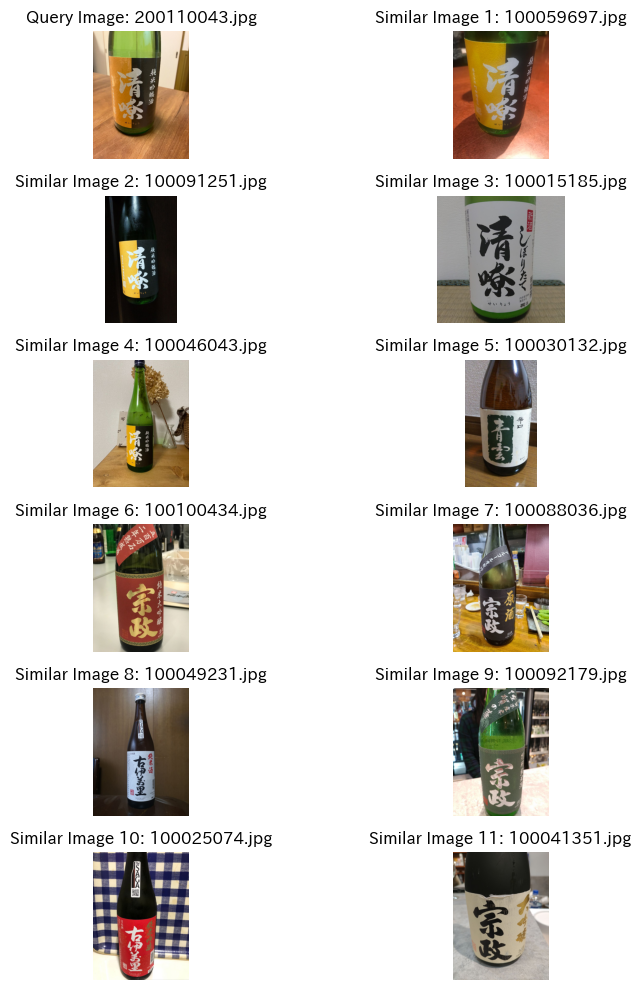

In [23]:
import cv2
import matplotlib.pyplot as plt

def display_similar_images(query_path, cite_paths):
    num_similar = len(cite_paths)

    # Query画像の読み込み
    query_image = cv2.imread(query_path)
    query_image = cv2.cvtColor(query_image, cv2.COLOR_BGR2RGB)

    # 類似画像の読み込みと表示
    num_rows = (num_similar + 1) // 2
    fig, axs = plt.subplots(num_rows, 2, figsize=(10, 10), squeeze=False)

    axs[0, 0].imshow(query_image)
    axs[0, 0].set_title(f'Query Image: {query_path.split("/")[-1]}')
    axs[0, 0].axis('off')

    for i, path in enumerate(cite_paths):
        similar_image = cv2.imread(path)
        similar_image = cv2.cvtColor(similar_image, cv2.COLOR_BGR2RGB)

        axs[(i+1)//2, (i+1)%2].imshow(similar_image)
        axs[(i+1)//2, (i+1)%2].set_title(f'Similar Image {i+1}: {path.split("/")[-1]}')
        axs[(i+1)//2, (i+1)%2].axis('off')

    # 空白のsubplotを削除
    if num_similar % 2 != 0:
        axs[num_rows-1, 1].axis('off')

    plt.tight_layout()
    plt.show()


def get_qyery_and_cite_path(submission_df, query_gid=None, k=4):
    if query_gid is None:
        query_gid = submission_df["gid"].sample(1).to_numpy()[0]

    cites = submission_df.loc[submission_df["gid"] ==query_gid, "cite_gid"].to_numpy()[0].split(" ")[:k]

    query_path = QUERY_IMAGES / f"{query_gid}.jpg"
    cite_paths = [(CITE_IMAGES / f"{cite_gid}.jpg").as_posix() for cite_gid in cites]
    return {"query_path":query_path.as_posix(), "cite_paths":cite_paths}


def plot_sake(submission_df, query_gid=None, k=11):
    path_dict = get_qyery_and_cite_path(submission_df, query_gid=query_gid, k=k)
    display_similar_images(**path_dict)


plot_sake(submission_df, query_gid=None)